# Intro
The goal of this notebook is to show how we can use different deep learning techniques in audio processing specifically for music. We will first show how to build a custom neural network to classify instrumentation of an audio sample. The data comes from freesound.org. For more info on the data, please refer to the freesound_API notebook

# Prep
Import necessary packages

In [1]:
# build training set
# imports
import os
import glob
import pickle
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from torchvision import transforms as vt


## Define user functions

In [2]:
def check_dict(py_dict,dict_key):
    if dict_key in py_dict:
        val = py_dict[dict_key]
    else:
        val = ''
    return val

In [3]:
def find_matching_strings(string_list, target_string):
    # make case insensitive
    lower_target_string = target_string.lower()
    matching_strings = [s.lower() for s in string_list if s.lower() in lower_target_string]
    return matching_strings

# Preprocess Data
Using the structure of our file system, we will create a dataframe that contains the location of the file as well as some basic info

In [8]:
def test_func(string: str) -> bool:
    print("done")
    
test_func(2)

done


In [12]:
import os

def check_wav_files(directory: str) -> bool:
    """
    Checks if there are any .wav files in the given directory and its subdirectories.

    Parameters:
    directory (str): The path to the directory to check.

    Returns:
    bool: True if there are .wav files in the directory or any of its subdirectories, False otherwise.

    Raises:
    ValueError: If the path is not a valid directory.
    """
    if not os.path.isdir(directory):
        raise ValueError(f"The path {directory} is not a valid directory.")
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.wav'):
                return True
    return False

# Example usage:
directory_path = "./freesound/247147"
has_wav_files = check_wav_files(directory_path)
print(f"Are there any .wav files in the directory or its subdirectories? {has_wav_files}")


Are there any .wav files in the directory or its subdirectories? True


In [32]:
def get_wav_files(directory:str) -> list:
    wav_files = glob.glob(os.path.join(directory, '**', '*.wav'),
                            recursive=True)
    # skip if more/less than 1 file found
    if len(wav_files) == 1:
        wav_file = wav_files[0]

In [27]:
import os

def check_metadata(file_path: str) -> bool:
    """
    Checks if there is a sound_metadata.pkl file in the directory.

    Parameters:
    directory (str): The path to the directory to check.

    Returns:
    bool: True if there is a sound_metadata.pkl in the directory or any of its subdirectories, False otherwise.

    Raises:
    ValueError: If the path is not a valid directory.
    """
    if not os.path.isdir(os.path.dirname(file_path)):
        raise ValueError(f"The path {file_path} is not a valid directory.")
    
    # check if file exists:
    metadata_exists = os.path.isfile(file_path)
    return metadata_exists

# Example usage:
file_path = "./freesound/247147/sound_metadata.pkl"
has_metadata = check_metadata(file_path)
print(f"Are there any metadata files in the directory or its subdirectories? {has_metadata}")


Are there any metadata files in the directory or its subdirectories? True


In [37]:
instrument_list = ['Clarinet','Sax Alto','Flute','Violin','Trumpet','Cello','Sax Tenor','Piccolo','Sax Soprano','Sax Baritone','Oboe','Double Bass']
def create_music_record(dir_path: str, instrument_list: list) -> dict:
    """
    Create a record for a dataframe from a file path

    Args:
        dir_path: string containing freesound file path
        instrument_list: list contraining valid instrument names

    Returns:
        music_record, a dictionary containing file information

    Raises:
        KeyError: Raises an exception if args are not proper format.
    """
    # check if wav file is in directory
    has_wav_files = check_wav_files(dir_path)
    # get sound_metadata 
    metadata_file = os.path.join(dir_path,'sound_metadata.pkl')
    has_metadata = check_metadata(metadata_file)
    
    if has_wav_files is False:
        print('No wav files found')
        return None
    elif has_metadata is False:
        print('No metadata file found')
        return None
    else:
        wav_file = get_wav_files(dir_path)
        with open(metadata_file, 'rb') as file:
            sound_metadata = pickle.load(file)
        # format metadata
        try:
            sound_name = sound_metadata['name']
            found_instruments = find_matching_strings(instrument_list,
                                                      sound_name)
            if len(found_instruments) == 1:
                sound_instr = found_instruments[0]
            else:
                # default to blank and investigate later
                sound_instr = ''
        except IndexError as e:
            print(e)
            sound_instr = ''
        music_record = {"relative_path":wav_file,
                        "channels":check_dict(sound_metadata,"channels"),
                        "filesize":check_dict(sound_metadata,"filesize"),
                        "bitrate":check_dict(sound_metadata,"bitrate"),
                        "bitdepth":check_dict(sound_metadata,"bitdepth"),
                        "duration":check_dict(sound_metadata,"duration"),
                        "samplerate":check_dict(sound_metadata,"samplerate"),
                        "instrument_name":sound_instr}
        return music_record
    
    
    

# create_music_record(dir_list[1])



In [36]:
def create_music_set(dir_list):
    music_list = [create_music_record(dir_,instrument_list = instrument_list) for dir_ in dir_list] 
    # filter
    music_fltrd = [i for i in music_list if i is not None]
    music_df = pd.DataFrame(music_fltrd)
    return music_df

dir_list = []
for root, dirs, files in os.walk("./freesound"):
        for directory in dirs:
            dir_list.append(os.path.join(root,directory))
print(len(dir_list))
music_df = create_music_set(dir_list)

7554
No wav files found


In [6]:
music_df.head()

,relative_path,channels,filesize,bitrate,bitdepth,duration,samplerate,instrument_name
0,./freesound\247147\overall quality of single n...,1,827734,0,24,5.74304,48000.0,trumpet
1,./freesound\247148\overall quality of single n...,1,882625,0,24,6.12423,48000.0,trumpet
2,./freesound\247149\overall quality of single n...,1,892381,0,24,6.19198,48000.0,trumpet
3,./freesound\247150\overall quality of single n...,1,965500,0,24,6.69975,48000.0,trumpet
4,./freesound\247151\overall quality of single n...,1,817732,0,24,5.67358,48000.0,trumpet


## Clean up 
We remove records where we were unable to parse the instrument from the file name

In [7]:
# clean up
n_missing = music_df.loc[music_df['instrument_name'] == ''].shape[0]
pct_missing = round(10*n_missing/music_df.shape[0],2)
print(f"Records missing target variable: {n_missing}. Removing  {pct_missing}% of records from our data")


music_df = music_df.loc[music_df['instrument_name'] != '']

Records missing target variable: 1. Removing  0.0% of records from our data


## Numerically encode target variable

In [8]:
# numerical encode target instrument
encoder = LabelEncoder()
music_df['target_instrument'] = encoder.fit_transform(music_df['instrument_name']).astype('int64')
music_df['target_instrument'].unique()

instrument_map = music_df[['instrument_name','target_instrument']].value_counts().reset_index()
instrument_map

,instrument_name,target_instrument,count
0,clarinet,1,1670
1,violin,11,1052
2,trumpet,10,829
3,cello,0,726
4,sax alto,6,717
5,flute,3,694
6,sax tenor,9,449
7,piccolo,5,388
8,sax soprano,8,334
9,sax baritone,7,288


Note that we have a slightly imbalanced dataset, with clarinets make up a high percentage, while the double bass makes up a low percentage

In [9]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
# inspo taken from: https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)


  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig]*new_channel)

    return ((resig, sr))


  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [10]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000 # 4 second audio clips
    self.sr = 44100 # default sample rate
    self.shift_pct = 0.4
    # self.transform_type = transform_type
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    # if self.transform_type == 'default':
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'target_instrument']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, 2)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id
    
    # elif self.transform_type == 'resnet':
    #   audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    #   # Get the Class ID
    #   class_id = self.df.loc[idx, 'target_instrument']

    #   aud = AudioUtil.open(audio_file)
    #   # Some sounds have a higher sample rate, or fewer channels compared to the
    #   # majority. So make all sounds have the same number of channels and same 
    #   # sample rate. Unless the sample rate is the same, the pad_trunc will still
    #   # result in arrays of different lengths, even though the sound duration is
    #   # the same.
    #   reaud = AudioUtil.resample(aud, self.sr)
    #   rechan = AudioUtil.rechannel(reaud, self.channel)

    #   dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    #   shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    #   sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    #   aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
      
    #   resnet_tfs = vt.Compose([
    #     vt.CenterCrop(224),
    #     vt.RandomHorizontalFlip(),
    #     # vt.ToTensor(),
    #     vt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    #   resnet_sg = resnet_tfs(aug_sg)

    #   return resnet_sg, class_id
      


In [11]:
test_file = music_df['relative_path'][3]
test_file

'./freesound\\247150\\overall quality of single note - trumpet - D#5.wav'

In [12]:
# walkthrough one example
aud = AudioUtil.open(test_file)
# print("audio file shape: ",aud.shape)
# resample
aud_resample = AudioUtil.resample(aud, newsr = 41000)
print("resampled audio shape: ",aud_resample[0].shape)

# rechannel
# aud_rechannel = aud_resample
aud_rechannel = AudioUtil.rechannel(aud_resample,2)

print("rechannel audio shape: ",aud_rechannel[0].shape)

# truncate

aud_trunc = AudioUtil.pad_trunc(aud_rechannel,4040)
print("truncated audio shape: ",aud_trunc[0].shape)

# time shift
aud_ts = AudioUtil.time_shift(aud_trunc, shift_limit = .4)
print("time shifted audio shape: ",aud_ts[0].shape)
# mel spectrogram
aud_sg = AudioUtil.spectro_gram(aud_ts, n_mels=64, n_fft=1024, hop_len=None)
print("audio spectrogram shape: ",aud_sg.shape)

# augmented spectrogram
aug_sg = AudioUtil.spectro_augment(aud_sg, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1)
print("augmented spectrogram shape: ",aug_sg.shape)

resampled audio shape:  torch.Size([1, 274690])
rechannel audio shape:  torch.Size([2, 274690])
truncated audio shape:  torch.Size([2, 165640])
time shifted audio shape:  torch.Size([2, 165640])
audio spectrogram shape:  torch.Size([2, 64, 324])
augmented spectrogram shape:  torch.Size([2, 64, 324])


2.3.0+cpu
2.3.0+cpu


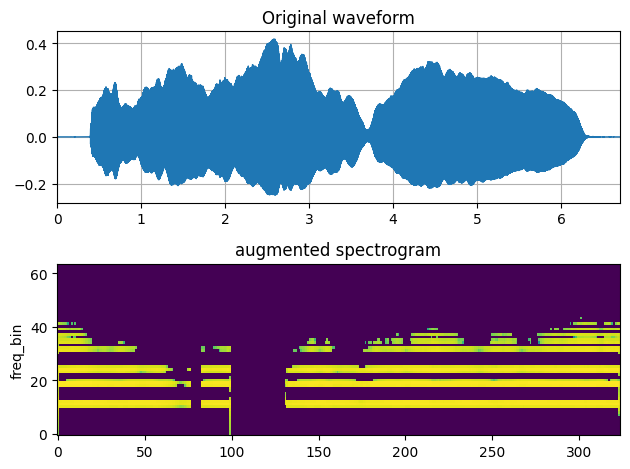

In [13]:
# plot spectrogram
import torch
import torchaudio
from torchaudio import functional
from torchaudio import transforms

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt

from IPython.display import Audio
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

# SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    

fig, axs = plt.subplots(2, 1)
plot_waveform(aud[0], aud[1], title="Original waveform", ax=axs[0])
plot_spectrogram(aug_sg[0], title="augmented spectrogram", ax=axs[1])
fig.tight_layout()

In [14]:
# original audio
SPEECH_WAVEFORM, SAMPLE_RATE = AudioUtil.open(test_file)
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

In [15]:
# modified audio
Audio(aud_ts[0].numpy(), rate=aud_ts[1])

# training

In [16]:
from torch.utils.data import random_split

data_path = ''

myds = SoundDS(music_df, data_path)
# def __init__(self, df, data_path,channel,transform_type = 'default')

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8) # 80% of data in training set
num_val =num_items - num_train
num_unused = num_items - num_train - num_val

train_ds, val_ds = random_split(myds, [num_train,num_val]) # temp for now to reduce size

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [17]:
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

# ----------------------------
# Audio Classification Model - custom architecture
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=12)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [18]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=5   # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 1.97, Accuracy: 0.42
Epoch: 1, Loss: 1.08, Accuracy: 0.67
Epoch: 2, Loss: 0.68, Accuracy: 0.79
Epoch: 3, Loss: 0.54, Accuracy: 0.84
Epoch: 4, Loss: 0.47, Accuracy: 0.86
Finished Training


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# cm = confusion_matrix(y_test, predictions)
# ConfusionMatrixDisplay(cm).plot()

# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    predictions = []
    labels_ = []
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # add prediction to confusion matrix
      [predictions.append(i) for i in prediction.tolist()]
      # predictions.append(prediction)
      # print(prediction.tolist())
      # add label to confusion matrix
      [labels_.append(i) for i in labels.tolist()]
      # print(labels)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')
  
  # return (labels_,)
  cm = confusion_matrix(labels_, predictions)
  return cm
  

# Run inference on trained model with the validation set
cm = inference(myModel, val_dl)


Accuracy: 0.85, Total items: 1510


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'cello'),
  Text(1, 0, 'clarinet'),
  Text(2, 0, 'double bass'),
  Text(3, 0, 'flute'),
  Text(4, 0, 'oboe'),
  Text(5, 0, 'piccolo'),
  Text(6, 0, 'sax alto'),
  Text(7, 0, 'sax baritone'),
  Text(8, 0, 'sax soprano'),
  Text(9, 0, 'sax tenor'),
  Text(10, 0, 'trumpet'),
  Text(11, 0, 'violin')])

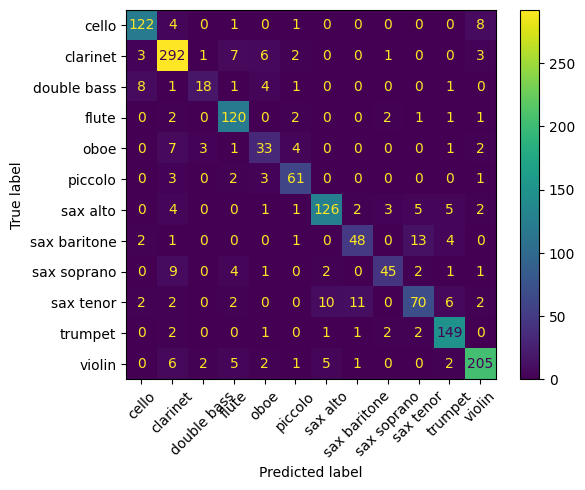

In [20]:
ConfusionMatrixDisplay(cm,display_labels = instrument_map.sort_values('target_instrument')['instrument_name']).plot()
plt.xticks(rotation = 45)

# next steps

As you can see, we achieved 87% accuracy on our validation set after only 5 epochs. By percentage, the trickiest instruments to differentiate appear to be the Violin and the Cello or the Oboe and the Clarinet. This type of work offers many avenues for future research!

In [21]:
# next steps:
# train on more data, more epochs

# can try additional transforms see: https://cs229.stanford.edu/proj2017/final-reports/5242716.pdf
# add additional metadata to model
# add analysis as features to the model

# play with architecture
## pre trained resnet model


# long term:
# create an app where you upload a file and i tell you what instrument it is